In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
vehicle_df = pd.read_csv('/home/arjunrao/mini_proj_6/train_model/vehicle_data.csv')
network_df = pd.read_csv('/home/arjunrao/mini_proj_6/train_model/network_data.csv')

# Merge on `time_step` and `ap_id`
vehicle_df['ap_id'] = vehicle_df['ap_id'].astype(str)
network_df['ap_id'] = network_df['ap_id'].str.extract(r'(\d+)').astype(str)  # clean `ap_1` to `1`
merged_df = pd.merge(network_df, vehicle_df, on=['time_step', 'ap_id'])

# Select relevant features
features = ['avg_packet_rate', 'avg_latency', 'bandwidth_usage', 'speed', 'acceleration', 'active_nodes']
merged_df = merged_df[["time_step", "ap_id"] + features]

# Normalize features
scalers = {}
for feature in features:
    scaler = MinMaxScaler()
    merged_df[feature] = scaler.fit_transform(merged_df[[feature]])
    scalers[feature] = scaler




In [2]:
merged_df.head()

,time_step,ap_id,avg_packet_rate,avg_latency,bandwidth_usage,speed,acceleration,active_nodes
0,0,1,0.425926,0.688785,0.618991,0.180205,0.554756,1.000000
1,0,1,0.425926,0.688785,0.618991,0.390136,0.558550,1.000000
2,0,1,0.425926,0.688785,0.618991,0.548845,0.469046,1.000000
3,0,1,0.425926,0.688785,0.618991,0.605852,0.423458,1.000000
4,0,2,0.462963,0.333425,0.398694,0.064575,0.676483,0.333333


In [3]:
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Process each AP separately
time_steps = 10
X_total, y_total = [], []

for ap_id in merged_df['ap_id'].unique():
    ap_data = merged_df[merged_df['ap_id'] == ap_id]
    ap_data = ap_data[features].values
    X, y = create_sequences(ap_data, time_steps)
    X_total.append(X)
    y_total.append(y)

X = np.vstack(X_total)
y = np.vstack(y_total)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)


2025-05-06 17:27:29.292266: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 17:27:30.467187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 17:27:35.306351: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 17:27:35.312998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 17:27:43.474596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           69120     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 118918 (464.52 KB)
Trainable params: 118918 (464.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
202/2

In [5]:
# Evaluate
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Save model
model.save("network_congestion_lstm.h5")


56/56 [==============================] - 0s 3ms/step - loss: 0.0172
Test Loss: 0.017165252938866615


/home/arjunrao/mini_proj_6/lstm_venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
predictions = model.predict(X_test)

# Inverse transform predictions
inv_predictions = predictions.copy()
for i, feature in enumerate(features):
    inv_predictions[:, i] = scalers[feature].inverse_transform(predictions)[:, i]

print("Sample Predictions:\n", inv_predictions[:5])


56/56 [==============================] - 1s 3ms/step
Sample Predictions:
 [[ 5.6057735e+01  1.3327868e+01  5.7779812e+01  2.9834160e+01
   5.2064419e-02  7.4374495e+00]
 [ 5.6191784e+01  1.0181514e+01  4.4668438e+01  2.9934862e+01
   3.6652397e-02  4.3846674e+00]
 [ 4.0882816e+01  1.8142153e+01  2.7530897e+01  2.9985973e+01
   1.1497245e-01  2.9931018e+00]
 [ 5.2016663e+01  1.1407001e+01  4.8036098e+01  2.9874062e+01
   8.5041691e-03  7.6065731e+00]
 [ 4.6197926e+01  1.3436161e+01  4.6255497e+01  2.9255371e+01
  -8.4033981e-02  8.4119644e+00]]


In [7]:
import joblib
model.save("network_congestion_lstm.h5")
for feat, scaler in scalers.items():
    joblib.dump(scaler, f"{feat}_scaler.save")


/home/arjunrao/mini_proj_6/lstm_venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


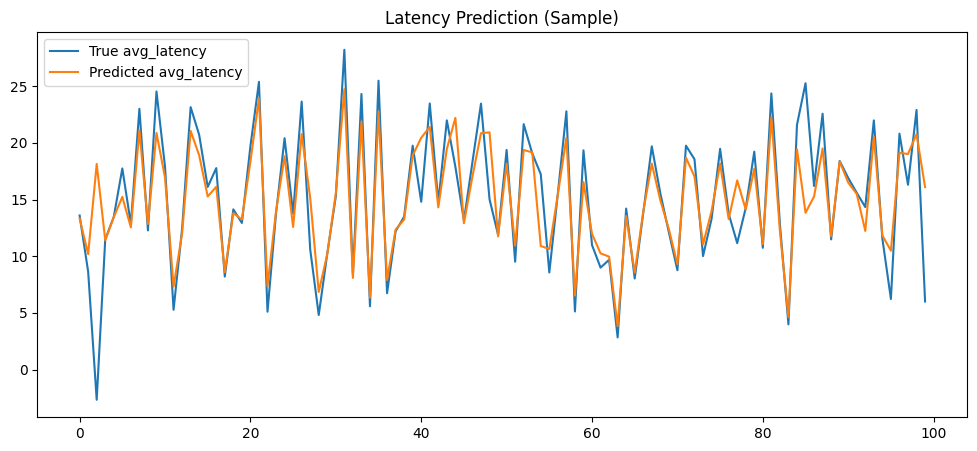

In [8]:
import matplotlib.pyplot as plt

# Just as example for avg_latency
true = scalers['avg_latency'].inverse_transform(y_test)[:,1]
pred = scalers['avg_latency'].inverse_transform(predictions)[:,1]

plt.figure(figsize=(12, 5))
plt.plot(true[:100], label="True avg_latency")
plt.plot(pred[:100], label="Predicted avg_latency")
plt.legend()
plt.title("Latency Prediction (Sample)")
plt.show()


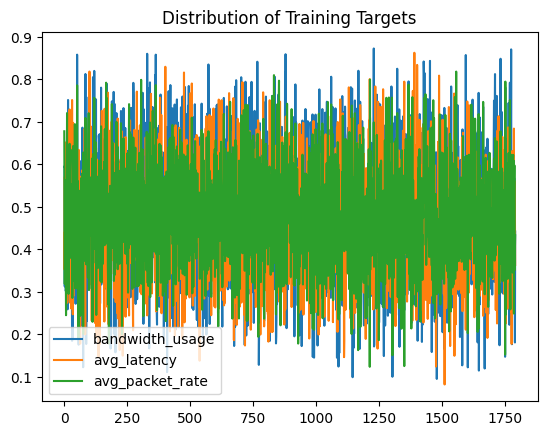

In [10]:
import matplotlib.pyplot as plt

# Plot true outputs
plt.plot(predictions[:, 0], label="bandwidth_usage")
plt.plot(predictions[:, 1], label="avg_latency")
plt.plot(predictions[:, 2], label="avg_packet_rate")
plt.legend()
plt.title("Distribution of Training Targets")
plt.show()
